# Defining MLP

In [1]:
# import os
# os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
# print(os.getcwd())

In [2]:
import os
os.chdir('c:\\Users\\mikol\\Documents\\Computational_Intelligence_Methods\\Computational_Intelligence_Methods')
print(os.getcwd())

c:\Users\mikol\Documents\Computational_Intelligence_Methods\Computational_Intelligence_Methods


In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

In [6]:
def relu(x):
    return np.maximum(0, x)

In [7]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [8]:
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Avoid overflow
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [9]:
def sigmoid_derivative(sigmoid_output):
    # Assumes that sigmoid_output is the result of sigmoid(x)
    return sigmoid_output * (1 - sigmoid_output)

In [10]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [11]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum(axis=0, keepdims=True)

In [12]:
def cross_entropy(softmax_output, y_true):
    # Assuming y_true is one-hot encoded
    m = y_true.shape[1]  # Number of examples
    log_likelihood = -np.log(softmax_output[y_true.argmax(axis=0), range(m)] + 1e-9)  # Small constant added
    loss = np.sum(log_likelihood) / m
    return loss

In [13]:
def cross_entropy_derivative(softmax_output, y_true):

    corrected_softmax_output = softmax_output - y_true
    
    return corrected_softmax_output
        


In [14]:
def softmax_derivative(softmax_output):
    # For softmax combined with cross-entropy loss, the derivative simplifies
    # the gradient calculation in backpropagation, directly using output error.
    return softmax_output

In [109]:
class MLP:
    def __init__(self, sizes, activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative):
        self.layer_sizes = sizes
        self.activation_fn = activation_fn
        self.layer_weights = [np.random.randn(y, x) * np.sqrt(2. / x) / 10 for x, y in zip(sizes[:-1], sizes[1:])]
        self.layer_biases = [np.zeros((y, 1)) for y in sizes[1:]]
        self.activation_fn_derivative = activation_fn_derivative

    def display_weights_biases(self):
        print("Final Weights and Biases:")
        for layer_index, (weights, biases) in enumerate(zip(self.layer_weights, self.layer_biases)):
            print(f"Layer {layer_index + 1} Weights:\n{weights}")
            print(f"Layer {layer_index + 1} Biases:\n{biases}")

    def propagate_forward(self, input_activation):
        activations = [input_activation]
        for biases, weights in zip(self.layer_biases, self.layer_weights[:-1]):
            input_activation = self.activation_fn(np.dot(weights, input_activation) + biases)
            activations.append(input_activation)
        final_input = np.dot(self.layer_weights[-1], input_activation) + self.layer_biases[-1]
        output_activation = softmax(final_input)
        activations.append(output_activation)
        # change
        return output_activation, activations

    def backward_propagation(self, input_val, true_val):
        weight_gradients = [np.zeros(weight.shape) for weight in self.layer_weights]
        bias_gradients = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Forward pass to get activations
        final_act, activations = self.propagate_forward(input_val)
        
        # Start with the derivative of the loss function w.r.t. the final activation
        error = cross_entropy_derivative(final_act, true_val)
        
        # Update gradients for the output layer
        bias_gradients[-1] = error
        weight_gradients[-1] = np.dot(error, activations[-2].T)
        
        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            # The derivative of the activation function is applied to the output of the activation function
            # from the forward pass, hence 'activations[-l]'
            activation_derivative = self.activation_fn_derivative(activations[-l])
            
            # Correct error propagation
            error = np.dot(self.layer_weights[-l+1].T, error) * activation_derivative
            
            bias_gradients[-l] = error
            weight_gradients[-l] = np.dot(error, activations[-l-1].T)
        
        return weight_gradients, bias_gradients

    
    def update_batch(self, batch, learn_rate, regularization, total_size, optimization_method, beta, epsilon=1e-8):
        gradient_w = [np.zeros(weight.shape) for weight in self.layer_weights]
        gradient_b = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        for input_val, true_val in batch:
            delta_gradient_w, delta_gradient_b = self.backward_propagation(input_val, true_val)
            gradient_w = [w + dw for w, dw in zip(gradient_w, delta_gradient_w)]
            gradient_b = [b + db for b, db in zip(gradient_b, delta_gradient_b)]

        # Update rule for weights and biases based on the optimization method
        if optimization_method == 'momentum':
            # Momentum initialization
            if not hasattr(self, 'velocity_weights'):
                self.velocity_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.velocity_biases = [np.zeros_like(b) for b in self.layer_biases]

            # Update velocities
            self.velocity_weights = [beta * vw + (1 - beta) * gw / len(batch) for vw, gw in zip(self.velocity_weights, gradient_w)]
            self.velocity_biases = [beta * vb + (1 - beta) * gb / len(batch) for vb, gb in zip(self.velocity_biases, gradient_b)]
            
            # Update weights and biases
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - learn_rate * vw
                                  for w, vw in zip(self.layer_weights, self.velocity_weights)]
            self.layer_biases = [b - learn_rate * vb for b, vb in zip(self.layer_biases, self.velocity_biases)]
        elif optimization_method == 'rmsprop':
            # RMSprop initialization
            if not hasattr(self, 'squared_gradients_weights'):
                self.squared_gradients_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.squared_gradients_biases = [np.zeros_like(b) for b in self.layer_biases]

            # Update squared gradients
            self.squared_gradients_weights = [beta * sgw + (1 - beta) * (gw**2) / len(batch)
                                              for sgw, gw in zip(self.squared_gradients_weights, gradient_w)]
            self.squared_gradients_biases = [beta * sgb + (1 - beta) * (gb**2) / len(batch)
                                             for sgb, gb in zip(self.squared_gradients_biases, gradient_b)]
            
            # Update weights and biases
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - 
                                  learn_rate * gw / (np.sqrt(sgw) + epsilon)
                                  for w, sgw, gw in zip(self.layer_weights, self.squared_gradients_weights, gradient_w)]
            self.layer_biases = [b - learn_rate * gb / (np.sqrt(sgb) + epsilon)
                                 for b, sgb, gb in zip(self.layer_biases, self.squared_gradients_biases, gradient_b)]

    def train(self, training_data, epochs, learn_rate, batch_size, regularization=0.0, optimization_method='rmsprop', beta=0.9, epsilon=1e-8, visual_interval=10, X_val=None, y_val=None, target = None,adaptive_learn_rate = True, decay_rate=0.1, decay_step=100):
        n = len(training_data)

        f1_history = []
        
        # Determine mini-batch size based on whether the batch_size_input is a percentage or fixed value
        if isinstance(batch_size, float):  # If batch_size_input is a float, treat it as a percentage
            batch_size = max(1, min(n, int(n * batch_size / 100)))
        elif isinstance(batch_size, int):  # If batch_size_input is an integer, treat it as a fixed size
            batch_size = max(1, min(n, batch_size))
        else:  # Raise an error if batch_size_input is neither float nor int
            raise ValueError("batch_size_input must be an integer (fixed size) or a float (percentage of dataset)")
        
        
        for epoch in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
    
            for mini_batch in mini_batches:
                self.update_batch(mini_batch, learn_rate, regularization, n, optimization_method, beta, epsilon)
            if adaptive_learn_rate:
                # Decay the learning rate every decay_step epochs
                if epoch % decay_step == 0 and epoch > 0:
                    learn_rate *= (1. / (1. + decay_rate * epoch))
    
            if epoch % visual_interval == 0:
                predictions = np.argmax(np.array([self.propagate_forward(x.reshape(-1, 1))[0] for x in X_val]), axis=1)
                accuracy = np.mean(predictions == y_val)
                print(f'epoch: {epoch}', f'Test accuracy: {accuracy}')
                
                f1_weighted = f1_score(y_val, predictions, average='weighted')
                f1_history.append((epoch,f1_weighted))
                print(f"F1 Score (Weighted): {f1_weighted}")
                
                if f1_weighted > target:
                    break
        return f1_history

    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            
    
        plt.show()




In [110]:
class MLP2:
    def __init__(self, sizes, activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative):
        self.layer_sizes = sizes
        self.activation_fn = activation_fn
        self.layer_weights = [np.random.randn(y, x) * np.sqrt(2. / x) / 10 for x, y in zip(sizes[:-1], sizes[1:])]
        self.layer_biases = [np.zeros((y, 1)) for y in sizes[1:]]
        self.activation_fn_derivative = activation_fn_derivative

    def display_weights_biases(self):
        print("Final Weights and Biases:")
        for layer_index, (weights, biases) in enumerate(zip(self.layer_weights, self.layer_biases)):
            print(f"Layer {layer_index + 1} Weights:\n{weights}")
            print(f"Layer {layer_index + 1} Biases:\n{biases}")

    def propagate_forward(self, input_activation):
        activations = [input_activation]
        for biases, weights in zip(self.layer_biases, self.layer_weights[:-1]):
            input_activation = self.activation_fn(np.dot(weights, input_activation) + biases)
            activations.append(input_activation)
        final_input = np.dot(self.layer_weights[-1], input_activation) + self.layer_biases[-1]
        output_activation = final_input
        activations.append(output_activation)
        return output_activation, activations

    def backward_propagation(self, input_val, true_val):
        weight_gradients = [np.zeros(weight.shape) for weight in self.layer_weights]
        bias_gradients = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Forward pass to get activations
        final_act, activations = self.propagate_forward(input_val)
        
        # Start with the derivative of the loss function w.r.t. the final activation
        error = cross_entropy_derivative(final_act, true_val)
        
        # Update gradients for the output layer
        bias_gradients[-1] = error
        weight_gradients[-1] = np.dot(error, activations[-2].T)
        
        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            # The derivative of the activation function is applied to the output of the activation function
            # from the forward pass, hence 'activations[-l]'
            activation_derivative = self.activation_fn_derivative(activations[-l])
            
            # Correct error propagation
            error = np.dot(self.layer_weights[-l+1].T, error) * activation_derivative
            
            bias_gradients[-l] = error
            weight_gradients[-l] = np.dot(error, activations[-l-1].T)
        
        return weight_gradients, bias_gradients

    
    def update_batch(self, batch, learn_rate, regularization, total_size, optimization_method, beta, epsilon=1e-8):
        gradient_w = [np.zeros(weight.shape) for weight in self.layer_weights]
        gradient_b = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        for input_val, true_val in batch:
            delta_gradient_w, delta_gradient_b = self.backward_propagation(input_val, true_val)
            gradient_w = [w + dw for w, dw in zip(gradient_w, delta_gradient_w)]
            gradient_b = [b + db for b, db in zip(gradient_b, delta_gradient_b)]

        # Update rule for weights and biases based on the optimization method
        if optimization_method == 'momentum':
            # Momentum initialization
            if not hasattr(self, 'velocity_weights'):
                self.velocity_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.velocity_biases = [np.zeros_like(b) for b in self.layer_biases]

            # Update velocities
            self.velocity_weights = [beta * vw + (1 - beta) * gw / len(batch) for vw, gw in zip(self.velocity_weights, gradient_w)]
            self.velocity_biases = [beta * vb + (1 - beta) * gb / len(batch) for vb, gb in zip(self.velocity_biases, gradient_b)]
            
            # Update weights and biases
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - learn_rate * vw
                                  for w, vw in zip(self.layer_weights, self.velocity_weights)]
            self.layer_biases = [b - learn_rate * vb for b, vb in zip(self.layer_biases, self.velocity_biases)]
        elif optimization_method == 'rmsprop':
            # RMSprop initialization
            if not hasattr(self, 'squared_gradients_weights'):
                self.squared_gradients_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.squared_gradients_biases = [np.zeros_like(b) for b in self.layer_biases]

            # Update squared gradients
            self.squared_gradients_weights = [beta * sgw + (1 - beta) * (gw**2) / len(batch)
                                              for sgw, gw in zip(self.squared_gradients_weights, gradient_w)]
            self.squared_gradients_biases = [beta * sgb + (1 - beta) * (gb**2) / len(batch)
                                             for sgb, gb in zip(self.squared_gradients_biases, gradient_b)]
            
            # Update weights and biases
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - 
                                  learn_rate * gw / (np.sqrt(sgw) + epsilon)
                                  for w, sgw, gw in zip(self.layer_weights, self.squared_gradients_weights, gradient_w)]
            self.layer_biases = [b - learn_rate * gb / (np.sqrt(sgb) + epsilon)
                                 for b, sgb, gb in zip(self.layer_biases, self.squared_gradients_biases, gradient_b)]

    def train(self, training_data, epochs, learn_rate, batch_size, regularization=0.0, optimization_method='rmsprop', beta=0.9, epsilon=1e-8, visual_interval=10, X_val=None, y_val=None, target = None,adaptive_learn_rate = True, decay_rate=0.1, decay_step=100):
        n = len(training_data)

        f1_history = []
        
        # Determine mini-batch size based on whether the batch_size_input is a percentage or fixed value
        if isinstance(batch_size, float):  # If batch_size_input is a float, treat it as a percentage
            batch_size = max(1, min(n, int(n * batch_size / 100)))
        elif isinstance(batch_size, int):  # If batch_size_input is an integer, treat it as a fixed size
            batch_size = max(1, min(n, batch_size))
        else:  # Raise an error if batch_size_input is neither float nor int
            raise ValueError("batch_size_input must be an integer (fixed size) or a float (percentage of dataset)")
        
        
        for epoch in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
    
            for mini_batch in mini_batches:
                self.update_batch(mini_batch, learn_rate, regularization, n, optimization_method, beta, epsilon)
            if adaptive_learn_rate:
                # Decay the learning rate every decay_step epochs
                if epoch % decay_step == 0 and epoch > 0:
                    learn_rate *= (1. / (1. + decay_rate * epoch))
    
            if epoch % visual_interval == 0:
                predictions = np.argmax(np.array([self.propagate_forward(x.reshape(-1, 1))[0] for x in X_val]), axis=1)
                accuracy = np.mean(predictions == y_val)
                print(f'epoch: {epoch}', f'Test accuracy: {accuracy}')
                f1_weighted = f1_score(y_val, predictions, average='weighted')
                f1_history.append((epoch,f1_weighted))
                print(f"F1 Score (Weighted): {f1_weighted}")
                
                if f1_weighted > target:
                    break
        return f1_history
    
    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            
    
        plt.show()



In [47]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean

In [48]:
def plot_mse(mse_history):
    plt.plot(mse_history)
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

# Loading data

In [49]:
df_train_rings3_regular = pd.read_csv('./data/classification/rings3-regular-training.csv')
df_test_rings3_regular = pd.read_csv('./data/classification/rings3-regular-test.csv')

In [50]:
df_train_easy = pd.read_csv('./data/classification/easy-training.csv')
df_test_easy = pd.read_csv('./data/classification/easy-test.csv')

In [51]:
df_train_xor3 = pd.read_csv('./data/classification/xor3-training.csv')
df_test_xor3 = pd.read_csv('./data/classification/xor3-test.csv')

### rings 3 regular dataset

In [52]:
scaler_X = DataScaler("standardization")

In [53]:
# Scale features
X1_train_rings = df_train_rings3_regular[['x']].values.reshape(-1, 1)
X1_test_rings = df_test_rings3_regular[['x']].values.reshape(-1, 1)


In [54]:
X2_train_rings = df_train_rings3_regular[['y']].values.reshape(-1, 1)
X2_test_rings = df_test_rings3_regular[['y']].values.reshape(-1, 1)

In [55]:
X_train_rings = np.hstack((X1_train_rings, X2_train_rings))
X_test_rings = np.hstack((X1_test_rings, X2_test_rings))

In [56]:
X_train_rings_scaled = np.hstack((scaler_X.fit_transform(X1_train_rings), scaler_X.fit_transform(X2_train_rings)))
X_test_rings_scaled = np.hstack((scaler_X.transform(X1_test_rings), scaler_X.transform(X2_test_rings)))

In [57]:
y_train_rings = df_train_rings3_regular['c'].values.reshape(-1, 1)
y_test_rings = df_test_rings3_regular['c'].values.reshape(-1, 1)

In [58]:
# Encode the 'c' column into one-hot vectors for the training and test datasets
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded_rings = encoder.fit_transform(y_train_rings)
y_test_encoded_rings = encoder.transform(y_test_rings)

In [59]:
num_classes_rings = y_train_encoded_rings.shape[1] 
num_classes_rings

3

In [167]:
training_data_rings = [
    (X_train_rings[i].reshape(-1, 1), y_train_encoded_rings[i].reshape(-1, 1))
    for i in range(len(X_train_rings))
]

In [168]:
mlp_rings = MLP(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_1 = mlp_rings.train(training_data=training_data_rings, epochs=1000, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=0.82, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.568
F1 Score (Weighted): 0.5158153619952542
epoch: 10 Test accuracy: 0.6555
F1 Score (Weighted): 0.6431291915498255
epoch: 20 Test accuracy: 0.7515
F1 Score (Weighted): 0.750051490709791
epoch: 30 Test accuracy: 0.7115
F1 Score (Weighted): 0.710882248168975
epoch: 40 Test accuracy: 0.7355
F1 Score (Weighted): 0.7356034192837017
epoch: 50 Test accuracy: 0.7895
F1 Score (Weighted): 0.7884344176399688
epoch: 60 Test accuracy: 0.7735
F1 Score (Weighted): 0.7632617608488909
epoch: 70 Test accuracy: 0.7825
F1 Score (Weighted): 0.7822521985418456
epoch: 80 Test accuracy: 0.81
F1 Score (Weighted): 0.8083766221927022
epoch: 90 Test accuracy: 0.8015
F1 Score (Weighted): 0.7993615988484408
epoch: 100 Test accuracy: 0.808
F1 Score (Weighted): 0.8080001506462436
epoch: 110 Test accuracy: 0.7955
F1 Score (Weighted): 0.7960604124840263
epoch: 120 Test accuracy: 0.8065
F1 Score (Weighted): 0.805927764486975
epoch: 130 Test accuracy: 0.757
F1 Score (Weighted): 0.75906760015609

In [62]:
mlp_rings = MLP2(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_2 = mlp_rings.train(training_data=training_data_rings, epochs=1000, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=0.82, decay_rate=0.01, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.337
F1 Score (Weighted): 0.285385783513687
epoch: 10 Test accuracy: 0.496
F1 Score (Weighted): 0.5014289553044528
epoch: 20 Test accuracy: 0.6585
F1 Score (Weighted): 0.6565078616381952
epoch: 30 Test accuracy: 0.6695
F1 Score (Weighted): 0.6523563322541158
epoch: 40 Test accuracy: 0.6885
F1 Score (Weighted): 0.6910844723950587
epoch: 50 Test accuracy: 0.7305
F1 Score (Weighted): 0.7258081355139712
epoch: 60 Test accuracy: 0.7245
F1 Score (Weighted): 0.716502150234725
epoch: 70 Test accuracy: 0.73
F1 Score (Weighted): 0.7250703845639414
epoch: 80 Test accuracy: 0.736
F1 Score (Weighted): 0.7351240960582702
epoch: 90 Test accuracy: 0.717
F1 Score (Weighted): 0.7163904722762846
epoch: 100 Test accuracy: 0.761
F1 Score (Weighted): 0.7605596512563945
epoch: 110 Test accuracy: 0.726
F1 Score (Weighted): 0.7255031458538439
epoch: 120 Test accuracy: 0.6745
F1 Score (Weighted): 0.678062733808863
epoch: 130 Test accuracy: 0.7635
F1 Score (Weighted): 0.7636984458008714


In [63]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'f1_score'])

In [64]:
f1_1 = list_to_dataframe(f1_1)
f1_2 = list_to_dataframe(f1_2)

In [65]:
f1_1

,Epoch,f1_score
0,0,0.510881
1,10,0.583305
2,20,0.685062
3,30,0.618978
4,40,0.729044
5,50,0.649026
6,60,0.733257
7,70,0.714013
8,80,0.708394
9,90,0.744989


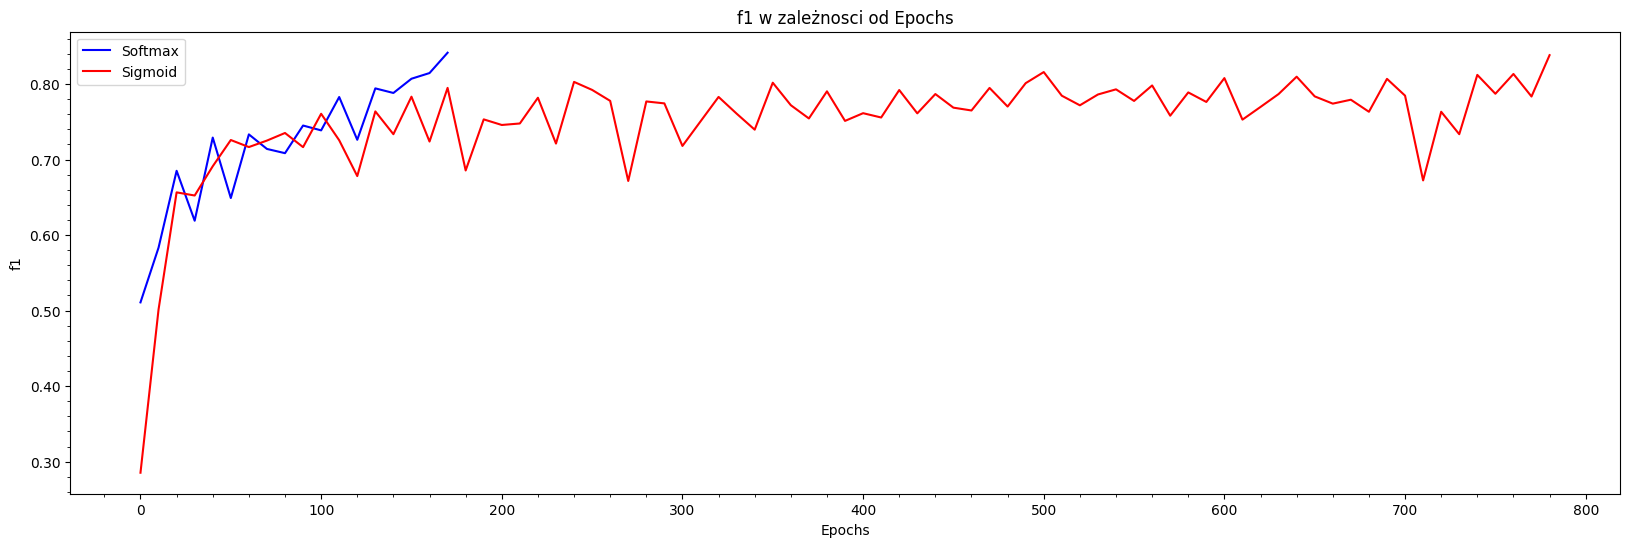

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(20, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['f1_score'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.title('f1 w zależnosci od Epochs')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.001)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [f1_1, f1_2]
labels = ['Softmax', 'Sigmoid']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)
'''
mlp_rings = MLP2(sizes=[2, 10, 10, 3], activation_fn=sigmoid,
                activation_fn_derivative=sigmoid_derivative)  # Example layer setup

# Train the MLP using your training data

f1_2 = mlp_rings.train(training_data=training_data_rings, epochs=1000, learn_rate=0.01, batch_size=64, X_val=X_test_rings,
                y_val=y_test_rings, visual_interval=10, target=0.82, decay_rate=0.01, adaptive_learn_rate=False)

f1 0.841376

'''


In [31]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_rings = np.argmax(np.array([mlp_rings.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_rings]), axis=1)

In [32]:
# Calculate accuracy or other metrics
accuracy_rings = np.mean(predictions_rings == y_test_rings)
print(f'Test accuracy: {accuracy_rings}')


Test accuracy: 0.7685


In [33]:
# Calculate F1 Score
f1_weighted_rings = f1_score(y_test_rings, predictions_rings, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_rings}")

F1 Score (Weighted): 0.7688619381461472


### easy dataset

In [112]:
# Scale features
X1_train_easy = df_train_easy[['x']].values.reshape(-1, 1)
X1_test_easy = df_test_easy[['x']].values.reshape(-1, 1)


In [113]:
X2_train_easy = df_train_easy[['y']].values.reshape(-1, 1)
X2_test_easy = df_test_easy[['y']].values.reshape(-1, 1)

In [114]:
X_train_easy= np.hstack((X1_train_easy, X2_train_easy))
X_test_easy = np.hstack((X1_test_easy, X2_test_easy))

In [115]:
y_train_easy = df_train_easy['c'].values.reshape(-1, 1)
y_test_easy = df_test_easy['c'].values.reshape(-1, 1)

In [116]:
# Encode the 'c' column into one-hot vectors for the training and test datasets
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded_easy = encoder.fit_transform(y_train_easy)
y_test_encoded_easy = encoder.transform(y_test_easy)

In [117]:
num_classes_easy = y_train_encoded_easy.shape[1] 
num_classes_easy

2

In [131]:
training_data_easy = [
    (X_train_easy[i].reshape(-1, 1), y_train_encoded_easy[i].reshape(-1, 1))
    for i in range(len(X_train_easy))
]

In [132]:
mlp_easy = MLP(sizes=[2, 2, 2], activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative)  

# Train the MLP using your training data
f1_3 = mlp_easy.train(training_data=training_data_easy, epochs=1000, learn_rate=0.01, batch_size=20, X_val=X_test_easy, y_val=y_test_easy, visual_interval=10, target = 0.99, decay_rate=0.001, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.882
F1 Score (Weighted): 0.8818956174373878
epoch: 10 Test accuracy: 0.994
F1 Score (Weighted): 0.9940000720025921


In [133]:
mlp_easy2 = MLP2(sizes=[2, 2, 2], activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative)  

# Train the MLP using your training data
f1_4 = mlp_easy2.train(training_data=training_data_easy, epochs=1000, learn_rate=0.01, batch_size=20, X_val=X_test_easy, y_val=y_test_easy, visual_interval=10, target = 0.99, decay_rate=0.001, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.986
F1 Score (Weighted): 0.9859997199719971


epoch: 10 Test accuracy: 0.984
F1 Score (Weighted): 0.984
epoch: 20 Test accuracy: 0.98
F1 Score (Weighted): 0.9799990399846397
epoch: 30 Test accuracy: 0.988
F1 Score (Weighted): 0.988
epoch: 40 Test accuracy: 0.982
F1 Score (Weighted): 0.9819967596759674
epoch: 50 Test accuracy: 0.992
F1 Score (Weighted): 0.992


In [134]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'f1_score'])

In [135]:
f1_3 = list_to_dataframe(f1_3)
f1_4 = list_to_dataframe(f1_4)

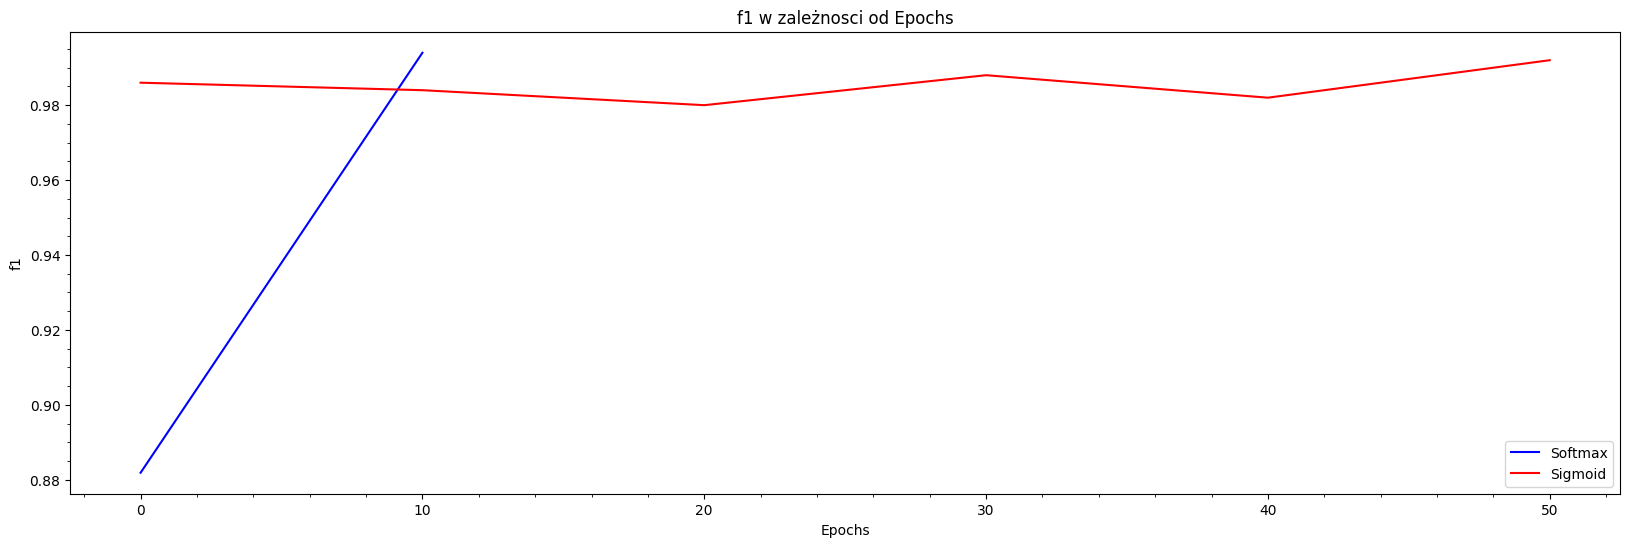

In [136]:
# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [f1_3, f1_4]
labels = ['Softmax', 'Sigmoid']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)

'''mlp_easy = MLP(sizes=[2, 2, 2], activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative)  

# Train the MLP using your training data
f1_3 = mlp_easy.train(training_data=training_data_easy, epochs=1000, learn_rate=0.01, batch_size=20, X_val=X_test_easy, 
y_val=y_test_easy, visual_interval=10, target = 0.99, decay_rate=0.001, adaptive_learn_rate=False)

mse 0.9940000720025921'''


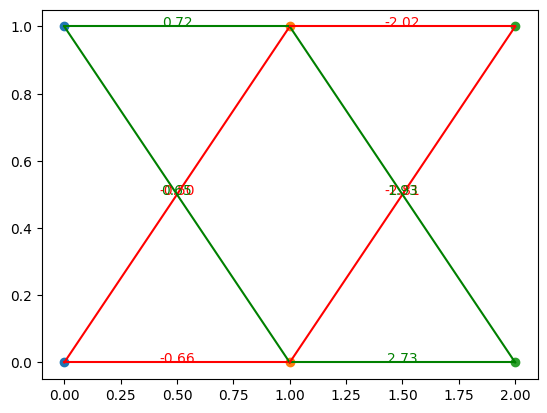

In [137]:
mlp_easy.visualize_network()

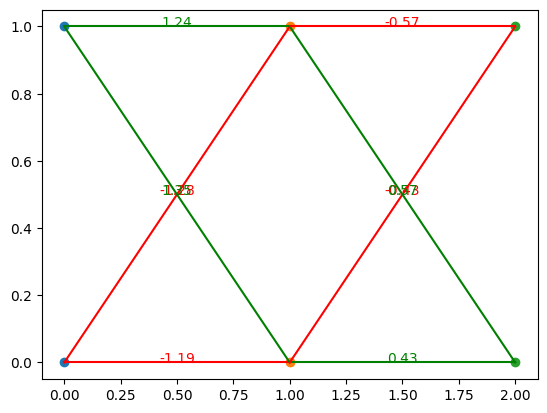

In [138]:
mlp_easy2.visualize_network()

In [40]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_easy = np.argmax(np.array([mlp_easy.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_easy]), axis=1)

In [41]:

# Calculate accuracy or other metrics
accuracy_easy = np.mean(predictions_easy == y_test_easy)
print(f'Test accuracy: {accuracy_easy}')


Test accuracy: 0.998


In [42]:
# Calculate F1 Score
f1_weighted_easy = f1_score(y_test_easy, predictions_easy, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_easy}")

F1 Score (Weighted): 0.9979999599959996


### xor3 dataset

In [169]:
# Scale features
X1_train_xor3 = df_train_xor3[['x']].values.reshape(-1, 1)
X1_test_xor3 = df_test_xor3[['x']].values.reshape(-1, 1)


In [170]:
X2_train_xor3 = df_train_xor3[['y']].values.reshape(-1, 1)
X2_test_xor3 = df_test_xor3[['y']].values.reshape(-1, 1)

In [171]:
X_train_xor3= np.hstack((X1_train_xor3, X2_train_xor3))
X_test_xor3 = np.hstack((X1_test_xor3, X2_test_xor3))

In [172]:
y_train_xor3 = df_train_xor3['c'].values.reshape(-1, 1)
y_test_xor3 = df_test_xor3['c'].values.reshape(-1, 1)

In [173]:
# Encode the 'c' column into one-hot vectors for the training and test datasets
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded_xor3 = encoder.fit_transform(y_train_xor3)
y_test_encoded_xor3 = encoder.transform(y_test_xor3)

In [174]:
num_classes_xor3 = y_train_encoded_xor3.shape[1] 
num_classes_xor3

2

In [175]:
training_data_xor3 = [
    (X_train_xor3[i].reshape(-1, 1), y_train_encoded_xor3[i].reshape(-1, 1))
    for i in range(len(X_train_xor3))
]

In [176]:
mlp_xor3 = MLP(sizes=[2, 15,15, 2], activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative)  

# Train the MLP using your training data
f1_5 = mlp_xor3.train(training_data=training_data_xor3, epochs=20000, learn_rate=0.001, batch_size=100, X_val=X_test_xor3, y_val=y_test_xor3, visual_interval=10, target = 0.97, decay_rate=0.0005, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.588
F1 Score (Weighted): 0.4354458438287153
epoch: 10 Test accuracy: 0.546
F1 Score (Weighted): 0.4697334302961264
epoch: 20 Test accuracy: 0.508
F1 Score (Weighted): 0.5021510323915869


epoch: 30 Test accuracy: 0.588
F1 Score (Weighted): 0.591101132269686
epoch: 40 Test accuracy: 0.666
F1 Score (Weighted): 0.6632799842973253
epoch: 50 Test accuracy: 0.688
F1 Score (Weighted): 0.6875407066052227
epoch: 60 Test accuracy: 0.71
F1 Score (Weighted): 0.7112713442097888
epoch: 70 Test accuracy: 0.71
F1 Score (Weighted): 0.7109829957699526
epoch: 80 Test accuracy: 0.708
F1 Score (Weighted): 0.7082008992143873
epoch: 90 Test accuracy: 0.71
F1 Score (Weighted): 0.7101009204036816
epoch: 100 Test accuracy: 0.832
F1 Score (Weighted): 0.8329930468482843
epoch: 110 Test accuracy: 0.842
F1 Score (Weighted): 0.8423680018402968
epoch: 120 Test accuracy: 0.852
F1 Score (Weighted): 0.852
epoch: 130 Test accuracy: 0.856
F1 Score (Weighted): 0.8561991570073763
epoch: 140 Test accuracy: 0.85
F1 Score (Weighted): 0.8500538297494957
epoch: 150 Test accuracy: 0.854
F1 Score (Weighted): 0.8544258550453522
epoch: 160 Test accuracy: 0.864
F1 Score (Weighted): 0.8636819425784943
epoch: 170 Test a

In [177]:
mlp_xor32 = MLP2(sizes=[2, 15, 15, 2], activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative)  

# Train the MLP using your training data
f1_6 = mlp_xor32.train(training_data=training_data_xor3, epochs=20000, learn_rate=0.001, batch_size=100, X_val=X_test_xor3, y_val=y_test_xor3, visual_interval=10, target = 0.97, decay_rate=0.0005, adaptive_learn_rate=False)

epoch: 0 Test accuracy: 0.412
F1 Score (Weighted): 0.24043059490084986
epoch: 10 Test accuracy: 0.588
F1 Score (Weighted): 0.4354458438287153
epoch: 20 Test accuracy: 0.422
F1 Score (Weighted): 0.28960601539875575
epoch: 30 Test accuracy: 0.538
F1 Score (Weighted): 0.5416050811573748
epoch: 40 Test accuracy: 0.736
F1 Score (Weighted): 0.736
epoch: 50 Test accuracy: 0.758
F1 Score (Weighted): 0.7596618384244599
epoch: 60 Test accuracy: 0.782
F1 Score (Weighted): 0.7830537221027507
epoch: 70 Test accuracy: 0.772
F1 Score (Weighted): 0.7725838294603418
epoch: 80 Test accuracy: 0.836
F1 Score (Weighted): 0.8362268177028451
epoch: 90 Test accuracy: 0.804
F1 Score (Weighted): 0.8055254515863937
epoch: 100 Test accuracy: 0.826
F1 Score (Weighted): 0.8271636314911137
epoch: 110 Test accuracy: 0.806
F1 Score (Weighted): 0.8073464844494744
epoch: 120 Test accuracy: 0.814
F1 Score (Weighted): 0.8152438819387766
epoch: 130 Test accuracy: 0.844
F1 Score (Weighted): 0.8451005692599619
epoch: 140 Tes

In [178]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'f1_score'])

In [179]:
f1_5 = list_to_dataframe(f1_5)
f1_6 = list_to_dataframe(f1_6)

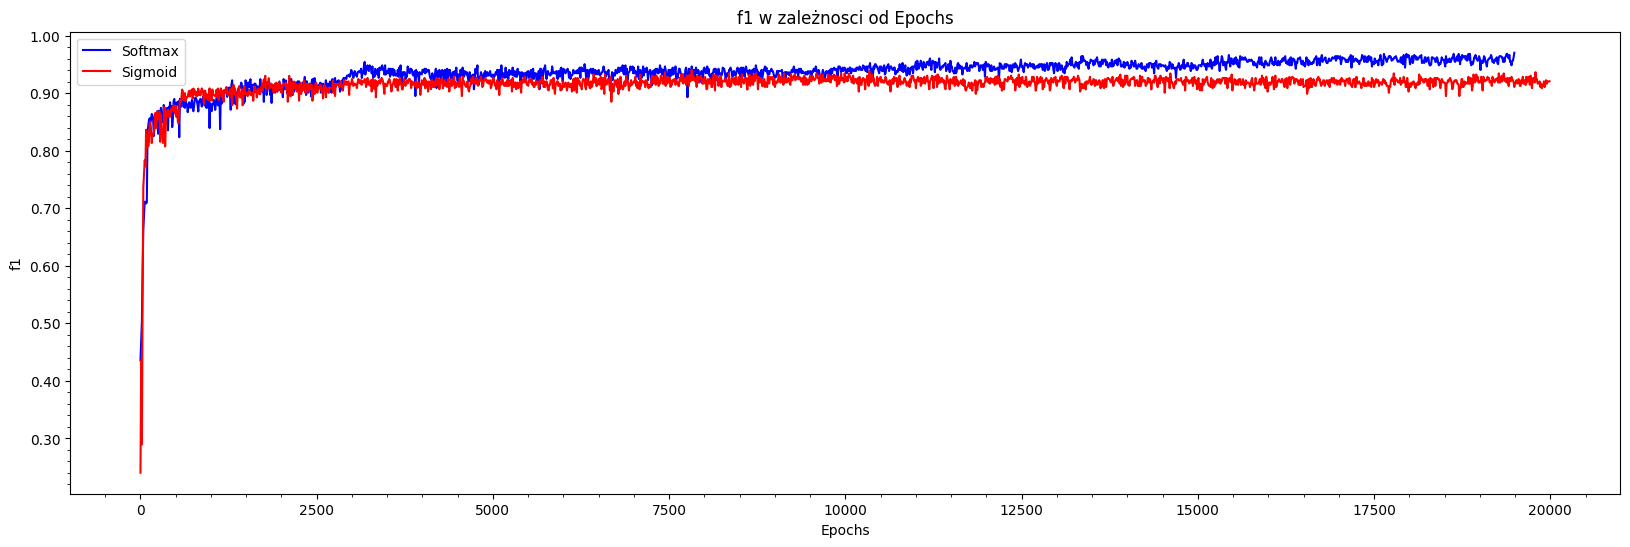

In [180]:
# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [f1_5, f1_6]
labels = ['Softmax', 'Sigmoid']
colors = ['blue', 'red']

plot_mse(datasets, labels, colors)

'''mlp_xor3 = MLP(sizes=[2, 15,15, 2], activation_fn=sigmoid, activation_fn_derivative=sigmoid_derivative)  

# Train the MLP using your training data
f1_5 = mlp_xor3.train(training_data=training_data_xor3, epochs=20000, learn_rate=0.001, batch_size=100, X_val=X_test_xor3, 
y_val=y_test_xor3, visual_interval=10, target = 0.97, decay_rate=0.0005, adaptive_learn_rate=False)

f1 0.9700875044613738'''


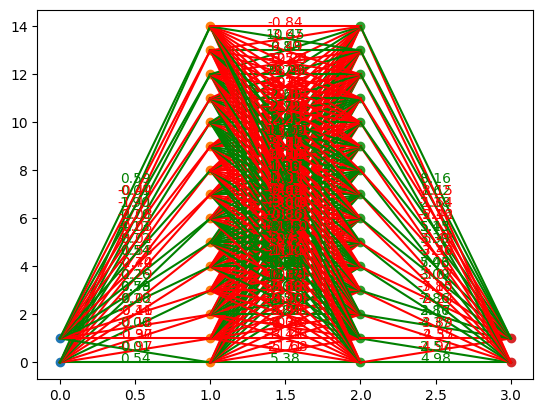

In [184]:
mlp_xor3.visualize_network()

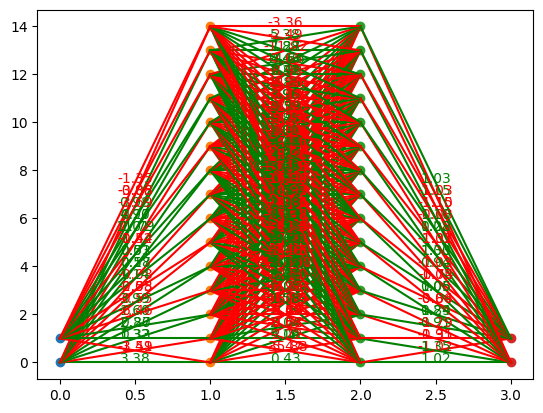

In [185]:
mlp_xor32.visualize_network()

In [186]:
# Predict on the test set
# This might involve looping through X_test_scaled and using your model's predict method
predictions_xor3 = np.argmax(np.array([mlp_xor3.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_xor3]), axis=1)

In [187]:

# Calculate accuracy or other metrics
accuracy_xor3 = np.mean(predictions_xor3 == y_test_xor3)
print(f'Test accuracy: {accuracy_xor3}')


Test accuracy: 0.97


In [189]:
# Calculate F1 Score
f1_weighted_xor3 = f1_score(y_test_xor3, predictions_xor3, average='weighted')

print(f"F1 Score (Weighted): {f1_weighted_xor3}")

F1 Score (Weighted): 0.9700875044613738
